## Load Data and Packages

In [1]:
# Packages
!pip install pandas
!pip install langid
!pip install nltk
!pip install gensim
!pip install top2vec
!pip install tensorflow
!pip install tensorflow_hub
!pip install transformers
!pip install matplotlib
!pip install torch
!pip install spacy
!pip install tdqm
!python -m spacy download en_core_web_sm

2023-05-26 17:11:35.060204: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 17:11:36.398527: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 20.6 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Data handling
import pandas as pd

# Disable truncation and wrapping of DataFrame columns
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Language detection
import langid

# Sentiment analysis
import nltk as nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.ticker as mtick

# LDA
import gensim

# top2vec
from top2vec import Top2Vec

# Graphs
import matplotlib.pyplot as plt
import numpy as np

# Download required nltk corpora
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

# Progress bars
from tqdm import tqdm


/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

In [3]:
# Load the dataset
print("Loading dataset...")
!git clone https://github.com/walkerkq/musiclyrics.git
df = pd.read_csv("musiclyrics/billboard_lyrics_1964-2015.csv", encoding= "latin")
print("Dataset loaded.")

Loading dataset...
fatal: destination path 'musiclyrics' already exists and is not an empty directory.
Dataset loaded.


## Dataset Exploration

In [4]:
# Dataset exploration prints
print("\nData Exploration")

print("\nDataframe shape:")
print(df.shape)

print("\nDataframe info:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

print("\nFirst few records:")
print(df.head())

print("\nColumn names:")
print(df.columns)

print("\nNull Values in Each Column:")
print(df.isnull().sum())


Data Exploration

Dataframe shape:
(5100, 6)

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5100 entries, 0 to 5099
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rank    5100 non-null   int64  
 1   Song    5100 non-null   object 
 2   Artist  5100 non-null   object 
 3   Year    5100 non-null   int64  
 4   Lyrics  4913 non-null   object 
 5   Source  4913 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 239.2+ KB
None

Summary Statistics:
            Rank         Year       Source
count  5100.0000  5100.000000  4913.000000
mean     50.5000  1990.000000     1.400977
std      28.8689    14.721045     0.890375
min       1.0000  1965.000000     1.000000
25%      25.7500  1977.000000     1.000000
50%      50.5000  1990.000000     1.000000
75%      75.2500  2003.000000     1.000000
max     100.0000  2015.000000     5.000000

First few records:
   Rank                               

## Preprocessing

In [5]:
# rename columns
df.columns = df.columns.str.lower()

In [6]:
# drop instrumental songs and songs with missing lyrics
df = df.dropna(subset=['lyrics'])
df = df[~df['lyrics'].str.strip().isin(['', 'instrumental', ' ', '  '])]
df.head(60)

,rank,song,artist,year,lyrics,source
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,3.0
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,1.0
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,1.0
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,1.0
5,6,downtown,petula clark,1965,when youre alone and life is making you lonel...,1.0
6,7,help,the beatles,1965,help i need somebody help not just anybody hel...,3.0
7,8,cant you hear my heart beat,hermans hermits,1965,carterlewis every time i see you lookin my way...,5.0
8,9,crying in the chapel,elvis presley,1965,you saw me crying in the chapel the tears i s...,1.0
9,10,my girl,the temptations,1965,ive got sunshine on a cloudy day when its cold...,3.0
10,11,help me rhonda,the beach boys,1965,well since she put me down i ve been out doin ...,3.0


In [7]:
# Drop the 'source' column as it's not needed
df = df.drop("source", axis=1)

In [8]:
# Detect language
def detect_language(text):
    lang, _ = langid.classify(text)
    return lang

tqdm.pandas(desc="Detecting Language")
df['language'] = df['lyrics'].progress_apply(detect_language)

Detecting Language: 100%|██████████| 4847/4847 [01:14<00:00, 64.98it/s] 


In [9]:
# Check the number of songs that are not in English
non_english_songs = df[df['language'] != 'en']
print("Number of songs not in English:", len(non_english_songs))
df.head(50)

Number of songs not in English: 21


,rank,song,artist,year,lyrics,language
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,en
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,en
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,en
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,en
5,6,downtown,petula clark,1965,when youre alone and life is making you lonel...,en
6,7,help,the beatles,1965,help i need somebody help not just anybody hel...,en
7,8,cant you hear my heart beat,hermans hermits,1965,carterlewis every time i see you lookin my way...,en
8,9,crying in the chapel,elvis presley,1965,you saw me crying in the chapel the tears i s...,en
9,10,my girl,the temptations,1965,ive got sunshine on a cloudy day when its cold...,en
10,11,help me rhonda,the beach boys,1965,well since she put me down i ve been out doin ...,en


In [10]:
# Filter only English songs and drop the 'language' column as it's not needed anymore
df = df[df['language'] == 'en'].drop(columns=['language'])

In [11]:
# Print the shape of the dataframe after preprocessing
print("Dataframe shape after preprocessing:", df.shape)

Dataframe shape after preprocessing: (4826, 5)


In [12]:
# Function to preprocess with nltk

def preprocess_with_nltk(df):
    """
    Function to preprocess lyrics with NLTK.

    Args:
    df : DataFrame - The dataframe containing song lyrics

    Returns:
    df : DataFrame - The dataframe with preprocessed lyrics
    """
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer
    from nltk.stem import WordNetLemmatizer
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('wordnet')

    # Define stopwords
    stop_words = set(stopwords.words('english'))
    custom_stopwords = ['im', 'like', 'dont', 'know', 'get', 'got', 'let', 'go', 'yeah', 'oh', 'wanna', 'want', 'ill', 'aint', 'ive', 'gonna', 'cant', 'em', 'ya', 'cause', 'make']
    stop_words = stop_words.union(set(custom_stopwords))

    # Preprocessing steps
    def preprocess_text(text):
        processed_text = text.lower().replace('[^\w\s]', '')
        processed_words = [word for word in processed_text.split() if word not in stop_words]
        return processed_words

    # Apply preprocessing to the lyrics column with progress bar
    tqdm.pandas(desc="Preprocessing with NLTK")
    df['processed_lyrics'] = df['lyrics'].progress_apply(preprocess_text)

    # Initialize Stemmer and Lemmatizer
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    # Function to get WordNet POS tag
    def get_wordnet_pos(word):
        from nltk.corpus import wordnet
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    return df

In [13]:
# Preprocessing with gensim

def preprocess_with_gensim(df):
    """
    Function to preprocess lyrics with Gensim and spaCy.

    Args:
    df : DataFrame - The dataframe containing song lyrics

    Returns:
    df : DataFrame - The dataframe with preprocessed lyrics
    """
    from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, stem_text
    from gensim.parsing.preprocessing import STOPWORDS as GENSIM_STOPWORDS
    import spacy

    # Custom stopwords
    custom_stopwords = ['im', 'like', 'dont', 'know', 'get', 'got', 'let', 'go', 'yeah', 'oh', 'wanna', 'want', 'ill', 'aint', 'ive', 'gonna', 'cant', 'em', 'ya', 'cause', 'make']
    STOPWORDS = GENSIM_STOPWORDS.union(set(custom_stopwords))

    # Define preprocessing steps
    CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, stem_text]

    # Apply the preprocessing
    tqdm.pandas(desc="Preprocessing with Gensim")
    df['processed_lyrics'] = df['lyrics'].progress_apply(lambda x: preprocess_string(x, CUSTOM_FILTERS))
    
    # Lemmatization using SpaCy
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    def lemmatize(text):
        doc = nlp(" ".join(text))
        return [token.lemma_ for token in doc]

    # Apply lemmatization
    tqdm.pandas(desc="Lemmatizing with spaCy")
    df['processed_lyrics'] = df['processed_lyrics'].progress_apply(lemmatize)

    return df

In [14]:
# Choose here which library to use for preprocessing
# df = preprocess_with_nltk(df)
df = preprocess_with_gensim(df)
df.head()

Lemmatizing with spaCy: 100%|██████████| 4826/4826 [01:03<00:00, 75.96it/s] 


,rank,song,artist,year,lyrics,processed_lyrics
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,"[sam, sham, miscellan, wooli, bulli, wooli, bu..."
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,"[sugar, pie, honei, bunch, know, love, help, l..."
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,"[wake, morn, mind, mind, get, troubl, whoaoh, ..."
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,"[close, ey, anymor, kiss, lip, there, tender, ..."
5,6,downtown,petula clark,1965,when youre alone and life is making you lonel...,"[your, life, make, lone, downtown, youv, get, ..."


## Sentiment Analysis

### Sentiment Analysis with NTLK Vader

In [15]:
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['processed_lyrics'].apply(lambda x: sia.polarity_scores(' '.join(x)))

df['compound'] = df['sentiment'].apply(lambda score_dict: score_dict['compound'])
df['sentiment_type'] = ''

def assign_sentiment_type(row):
    if row['compound'] > 0.33:
        return 'POSITIVE'
    elif row['compound'] < -0.33:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

df['sentiment_type'] = df.progress_apply(assign_sentiment_type, axis=1)

Lemmatizing with spaCy: 100%|██████████| 4826/4826 [00:00<00:00, 160577.13it/s]


In [16]:
df.sample(10)

,rank,song,artist,year,lyrics,processed_lyrics,sentiment,compound,sentiment_type
3762,63,lose yourself,eminem,2002,look if you had one shot or one opportunity t...,"[look, shoot, opportun, seiz, want, moment, ca...","{'neg': 0.158, 'neu': 0.706, 'pos': 0.136, 'co...",-0.8879,NEGATIVE
3942,43,jesus walks,kanye west,2004,order huh yo we at war we at war with terrori...,"[order, huh, yo, war, war, terror, racism, war...","{'neg': 0.279, 'neu': 0.597, 'pos': 0.124, 'co...",-0.9960,NEGATIVE
2323,24,hold on to the nights,richard marx,1988,just when i believed i couldnt ever want for ...,"[believ, want, chang, world, push, door, see, ...","{'neg': 0.06, 'neu': 0.649, 'pos': 0.292, 'com...",0.9647,POSITIVE
1873,74,im still standing,elton john,1983,you could never know what its like your blood...,"[know, like, blood, like, winter, freez, like,...","{'neg': 0.072, 'neu': 0.389, 'pos': 0.539, 'co...",0.9978,POSITIVE
110,11,summer in the city,lovin spoonful,1966,hot town summer in the city back of my neck g...,"[hot, town, summer, citi, neck, get, dirti, gr...","{'neg': 0.065, 'neu': 0.849, 'pos': 0.086, 'co...",0.0772,NEUTRAL
4852,53,try,pink,2013,ever wonder bout what hes doing how its all t...,"[wonder, bout, he, turn, li, think, well, ask,...","{'neg': 0.094, 'neu': 0.868, 'pos': 0.038, 'co...",-0.8807,NEGATIVE
424,25,get back,the beatles with billy preston,1969,jojo was a man who thought he was a loner but...,"[jojo, man, think, loner, know, jojo, leave, h...","{'neg': 0.072, 'neu': 0.866, 'pos': 0.062, 'co...",0.1280,NEUTRAL
2870,71,do you believe in us,jon secada,1993,i tremble inside just thinking about the worl...,"[trembl, insid, think, world, scare, help, won...","{'neg': 0.135, 'neu': 0.549, 'pos': 0.315, 'co...",0.9883,POSITIVE
4764,65,lets go,calvin harris featuring neyo,2012,lets go make no excuses now im talking here a...,"[let, excus, I, m, talk, I, m, talk, let, time...","{'neg': 0.0, 'neu': 0.818, 'pos': 0.182, 'comp...",0.9360,POSITIVE
470,71,when i die,motherlode,1969,when i die i hope to be a better man than you ...,"[die, hope, well, man, think, I, d, hard, kind...","{'neg': 0.206, 'neu': 0.397, 'pos': 0.397, 'co...",0.9628,POSITIVE


In [17]:
# Plots for vader
def plot_vader(df):
    plot_vader_bar(df)
    plot_vader_over_time(df)
    plot_vader_hist(df)

def plot_vader_bar(df):
    value_counts = df['sentiment_type'].value_counts(normalize=True) * 100
    ax = value_counts.plot(kind='bar')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.title('Vader: Distribution of Sentiment Types')
    plt.xlabel('Sentiment Type')
    plt.ylabel('Percentage')
    plt.show()

def plot_vader_over_time(df):
    grouped_data = df.groupby('year')['compound'].mean().reset_index()
    x = grouped_data['year']
    y = grouped_data['compound']
    m, b = np.polyfit(x, y, deg=1)

    plt.plot(x, y, label='Average sentiment')
    plt.plot(x, m*x + b, color='red', label='Regression'.format(m, b))

    plt.title('Vader: Average Sentiment Compound Score Per Year')
    plt.xlabel('Year')
    plt.ylabel('Average Compound Score')
    plt.legend()
    plt.show()

def plot_vader_hist(df):
    df['compound'].plot(kind='hist', bins=20)
    plt.title('Vader: Distribution of Sentiment Strength')
    plt.xlabel('Compound Score')
    plt.ylabel('Count')
    plt.show()

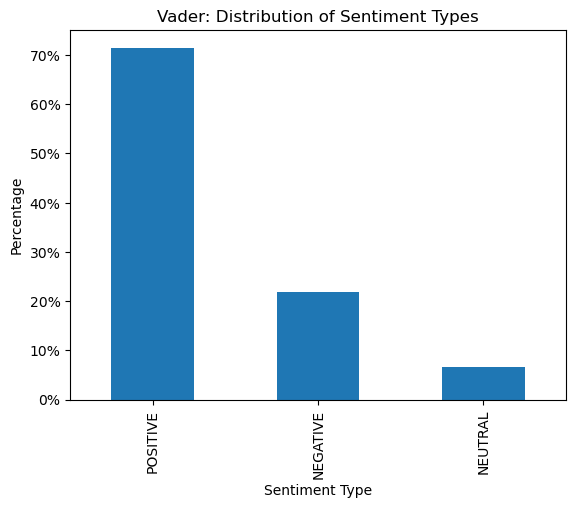

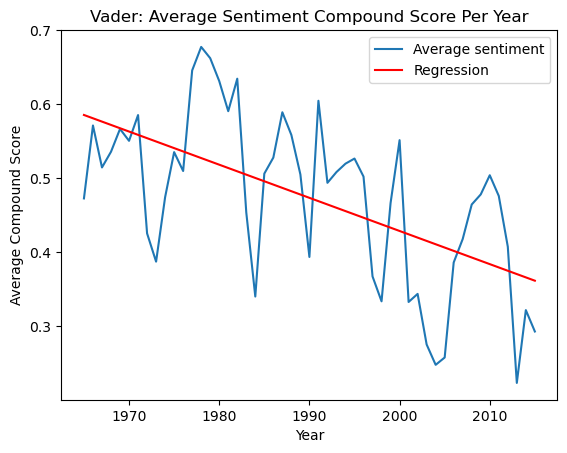

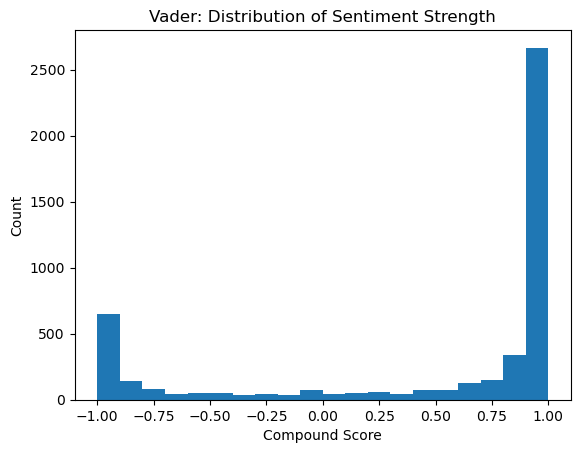

In [18]:
plot_vader(df)


## Topic Modeling

### General Preparation for LDA

In [19]:
# create dictionary with unique IDs for all words
dictionary = gensim.corpora.Dictionary(df['processed_lyrics'])

In [20]:
# filter out words from the dictionary for words that appear
# in less than 5 songs
# in more than 30% of the songs
dictionary.filter_extremes(no_below=5, no_above=0.3)
print(len(dictionary.iteritems()))

4910


In [21]:
# define functions for topic modeling results visualization
def plot_topic_evolution(df):
  # Group the DataFrame by year and topic, and count the occurrences
  topic_occurrences = df.groupby(['year', 'topic']).size().reset_index(name='occurrences')

  # Get the 5-year moving averages of topic occurrences
  topic_occurrences['moving_average'] = topic_occurrences.groupby('topic')['occurrences'].rolling(window=5).mean().reset_index(0, drop=True)

  # Pivot the table for plotting
  topic_occurrences_pivot = topic_occurrences.pivot(index='year', columns='topic', values='moving_average')

  # Plot the 10-year moving averages of topic occurrences
  topic_occurrences_pivot.plot(kind='line')
  plt.xlabel('Year')
  plt.ylabel('Topic Occurrences (Moving Average)')
  plt.title('Development of Topic Occurrences over Time (5-Year Moving Averages)')
  plt.legend(title='Topic')
  plt.legend(title='Topic', bbox_to_anchor=(1, 1))
  plt.show()

def plot_word_clouds(lda_model, dictionary):
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud

    # Generate word clouds for each topic
    for index, topic in enumerate(lda_model.get_topics()):
        # Convert topic to a list of tuples
        topic_list = [(id, weight) for id, weight in enumerate(topic)]

        # Sort the topic list by weight in descending order
        topic_list.sort(key=lambda x: x[1], reverse=True)

        # Get the top 50 words for the topic
        top_words = [dictionary[id] for id, _ in topic_list[:50]]

        # Create a string of words separated by spaces
        words_text = " ".join(top_words)

        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words_text)

        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic #{index} Word Cloud')
        plt.axis('off')
        plt.show()

def plot_topic_distribution(df):
    # Count the number of songs per topic
    topic_counts = df['topic'].value_counts()

    # Create the bar chart
    topic_counts.plot(kind='bar', color='skyblue')
    plt.title('Number of Songs per Topic')
    plt.ylabel('Number of Songs')
    plt.xlabel('topic')
    plt.xticks(rotation=0) # to keep the x-axis labels vertical
    plt.show()

### LDA

In [22]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in df['processed_lyrics']]

In [23]:
# lda on bag of words
lda_model = gensim.models.LdaMulticore(doc_term_matrix,
                                       num_topics=5,  # prespecified number of topics
                                       id2word=dictionary,  # dictionary that maps word ids to the preprocessed words
                                       passes=10,  # number of passes through the data during training
                                       iterations=200,  # Maximum number of iterations through the corpus when inferring the topic distribution of a corpus
                                       # workers=2,  # how many CPU cores will be used. If not specified, all but one will be used.
                                       random_state = 17)

In [24]:
# get the topic distribution
topic_distribution = lda_model[doc_term_matrix]

# Extract the most dominant topic and its probability for each document
df['topic'] = [max(topic, key=lambda item: item[1])[0] for topic in topic_distribution]
df['topic_probability'] = [max(topic, key=lambda item: item[1])[1] for topic in topic_distribution]

In [25]:
df.head()

,rank,song,artist,year,lyrics,processed_lyrics,sentiment,compound,sentiment_type,topic,topic_probability
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,"[sam, sham, miscellan, wooli, bulli, wooli, bu...","{'neg': 0.0, 'neu': 0.985, 'pos': 0.015, 'comp...",0.0772,NEUTRAL,2,0.874768
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,"[sugar, pie, honei, bunch, know, love, help, l...","{'neg': 0.094, 'neu': 0.475, 'pos': 0.431, 'co...",0.9918,POSITIVE,3,0.524793
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,"[wake, morn, mind, mind, get, troubl, whoaoh, ...","{'neg': 0.086, 'neu': 0.857, 'pos': 0.057, 'co...",-0.4939,NEGATIVE,0,0.982543
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,"[close, ey, anymor, kiss, lip, there, tender, ...","{'neg': 0.104, 'neu': 0.615, 'pos': 0.282, 'co...",0.9859,POSITIVE,1,0.724350
5,6,downtown,petula clark,1965,when youre alone and life is making you lonel...,"[your, life, make, lone, downtown, youv, get, ...","{'neg': 0.146, 'neu': 0.613, 'pos': 0.241, 'co...",0.9517,POSITIVE,1,0.601341


In [26]:
# Get the top words associated with each topic
topics = lda_model.show_topics(num_topics=5, num_words=10)

# Print the top words for each topic
for topic in topics:
    print(f"Topic {topic[0]}: \n{topic[1]}")
    print()

Topic 0: 
0.014*"iv" + 0.013*"awai" + 0.011*"dai" + 0.010*"life" + 0.009*"live" + 0.009*"heart" + 0.009*"world" + 0.008*"look" + 0.008*"d" + 0.008*"there"

Topic 1: 
0.031*"girl" + 0.024*"wanna" + 0.019*"good" + 0.018*"night" + 0.013*"ooh" + 0.013*"thing" + 0.011*"will" + 0.010*"ill" + 0.009*"tonight" + 0.009*"be"

Topic 2: 
0.023*"la" + 0.021*"na" + 0.017*"ill" + 0.011*"heart" + 0.009*"life" + 0.007*"girl" + 0.007*"fall" + 0.006*"night" + 0.006*"ey" + 0.006*"walk"

Topic 3: 
0.013*"ya" + 0.011*"wanna" + 0.011*"boi" + 0.010*"girl" + 0.009*"hei" + 0.008*"be" + 0.008*"nigga" + 0.008*"man" + 0.007*"littl" + 0.007*"ill"

Topic 4: 
0.020*"shake" + 0.012*"night" + 0.011*"bodi" + 0.011*"rock" + 0.010*"hand" + 0.010*"turn" + 0.009*"light" + 0.007*"parti" + 0.007*"round" + 0.006*"watch"



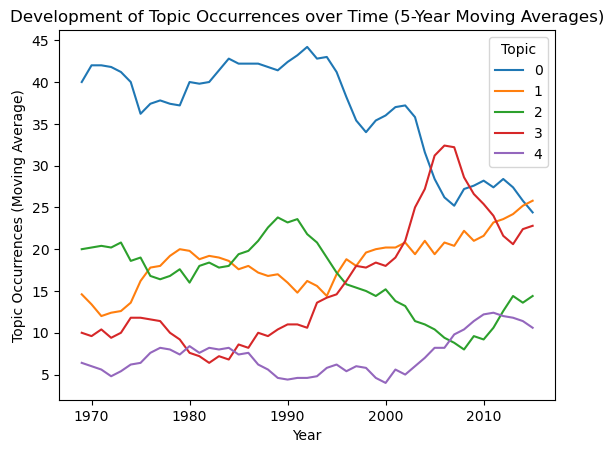

In [27]:
# topic 0 was most prominent, but occurences decreased in the last decades
# topic 3 saw an increase betweeen the 80s and late 2000's, but was less prominent again in the last decade
plot_topic_evolution(df)

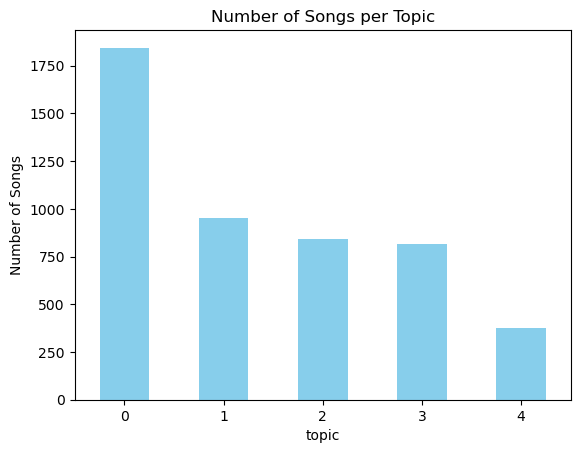

In [28]:
plot_topic_distribution(df)

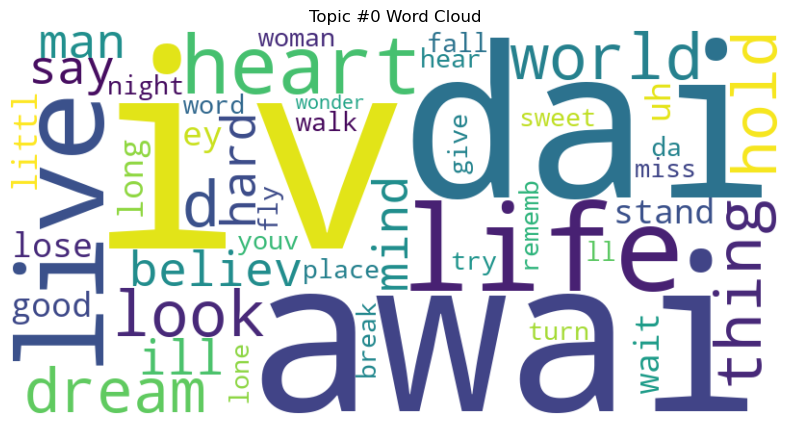

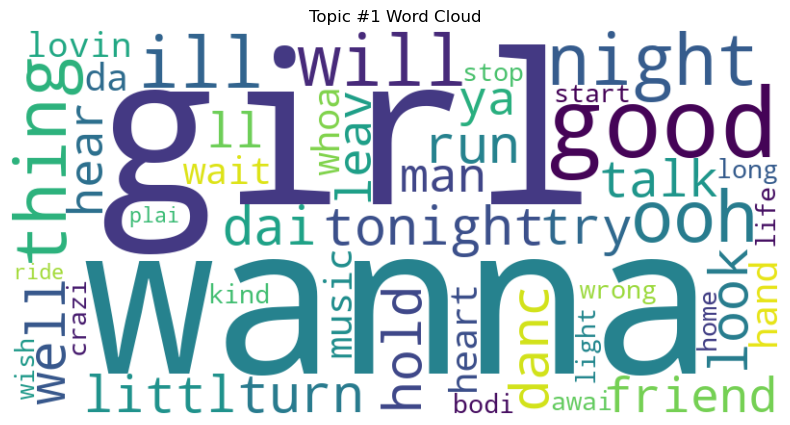

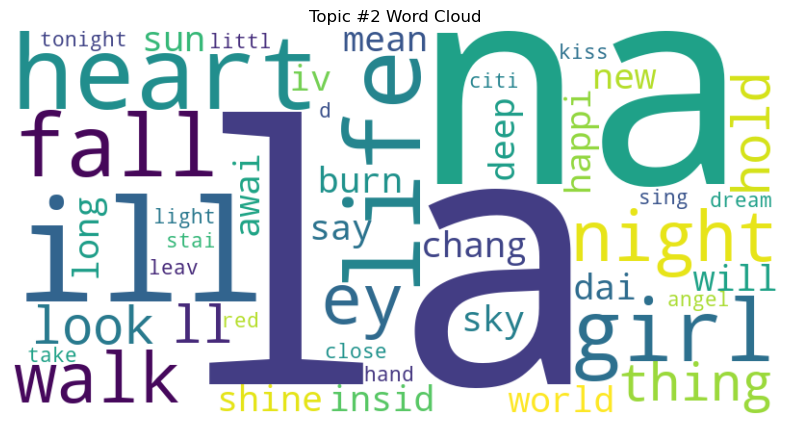

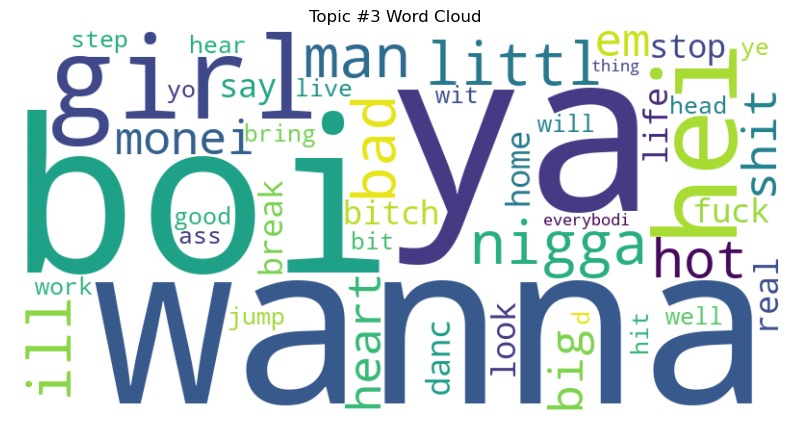

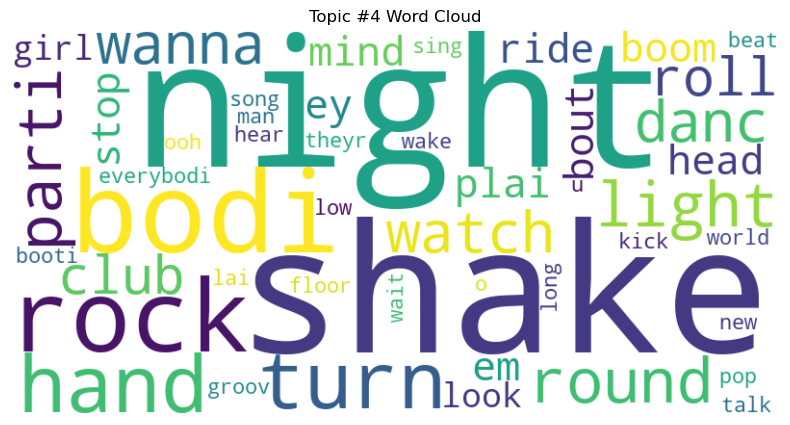

In [29]:
plot_word_clouds(lda_model, dictionary)

### LDA with Tf-Idf

In [30]:
# Convert the corpus into a bag-of-words representation
bow_corpus = [dictionary.doc2bow(doc) for doc in df['processed_lyrics']]

# Transform the bag-of-words corpus into TF-IDF representation
tfidf = gensim.models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

In [31]:
# lda on bag of words
lda_model = gensim.models.LdaMulticore(tfidf_corpus,
                                       num_topics=5,  # prespecified number of topics
                                       id2word=dictionary,  # dictionary that maps word ids to the preprocessed words
                                       passes=10,  # number of passes through the data during training
                                       iterations=200,  # Maximum number of iterations through the corpus when inferring the topic distribution of a corpus
                                       # workers=2,  # how many CPU cores will be used. If not specified, all but one will be used.
                                       random_state = 17)

In [32]:
# Get the top words associated with each topic
topics = lda_model.show_topics(num_topics=5, num_words=10)

# Print the top words for each topic
for topic in topics:
    print(f"Topic {topic[0]}: \n{topic[1]}")
    print()

Topic 0: 
0.004*"iv" + 0.004*"awai" + 0.003*"sweet" + 0.003*"lone" + 0.003*"heart" + 0.003*"da" + 0.003*"dai" + 0.003*"boogi" + 0.003*"world" + 0.003*"lose"

Topic 1: 
0.005*"heart" + 0.005*"hold" + 0.005*"ill" + 0.005*"wait" + 0.004*"tonight" + 0.004*"wanna" + 0.004*"awai" + 0.004*"iv" + 0.004*"will" + 0.004*"girl"

Topic 2: 
0.014*"na" + 0.010*"la" + 0.004*"heart" + 0.004*"ill" + 0.004*"awai" + 0.003*"fall" + 0.003*"rememb" + 0.003*"heaven" + 0.003*"dai" + 0.003*"life"

Topic 3: 
0.005*"girl" + 0.005*"wanna" + 0.004*"ill" + 0.003*"ya" + 0.003*"be" + 0.003*"night" + 0.003*"good" + 0.003*"man" + 0.003*"hei" + 0.003*"danc"

Topic 4: 
0.006*"shake" + 0.004*"u" + 0.003*"beauti" + 0.002*"sweet" + 0.002*"turn" + 0.002*"oo" + 0.002*"ey" + 0.002*"wake" + 0.002*"searchin" + 0.002*"world"



In [33]:
# get the topic distribution
topic_distribution = lda_model[doc_term_matrix]

# Extract the most dominant topic and its probability for each document
df['topic'] = [max(topic, key=lambda item: item[1])[0] for topic in topic_distribution]
df['topic_probability'] = [max(topic, key=lambda item: item[1])[1] for topic in topic_distribution]

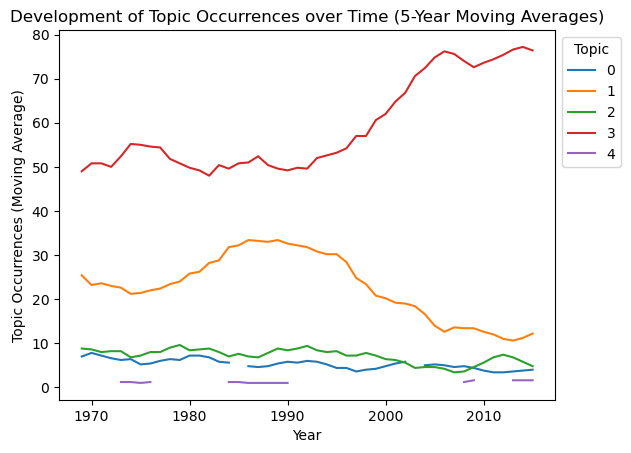

In [34]:
# with tfidf, technically only two topics are left, where one topic dominates
plot_topic_evolution(df)

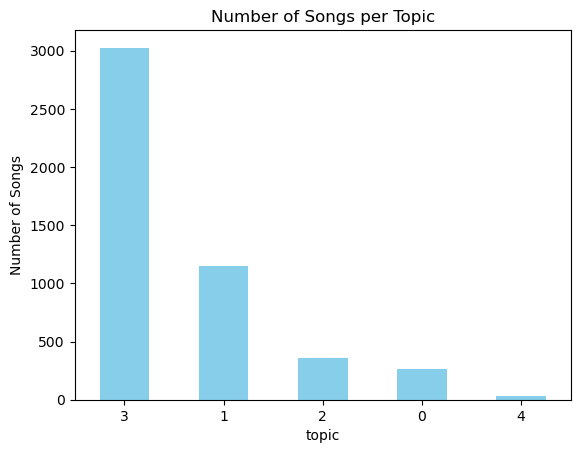

In [35]:
plot_topic_distribution(df)

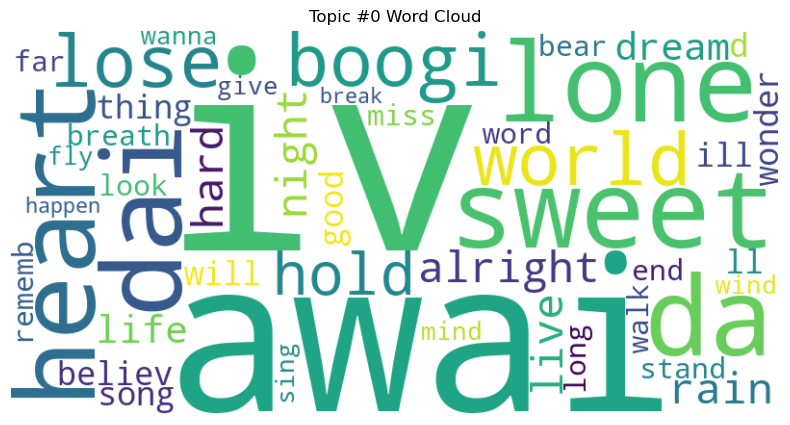

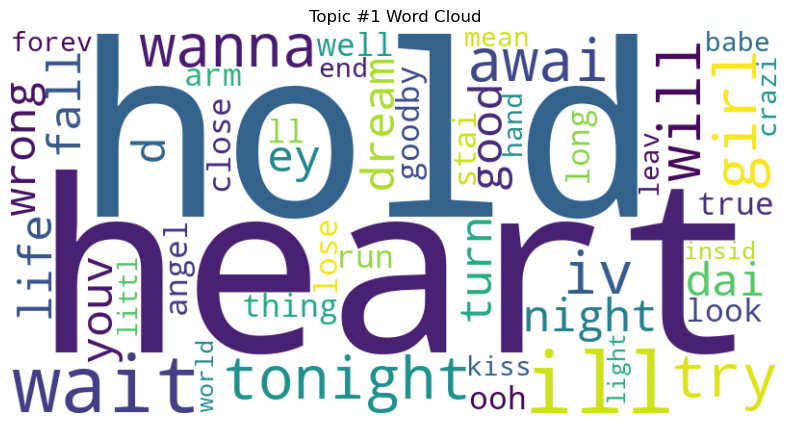

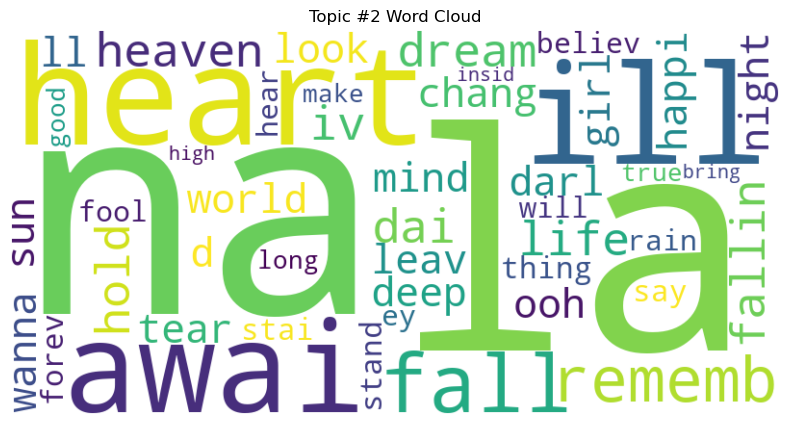

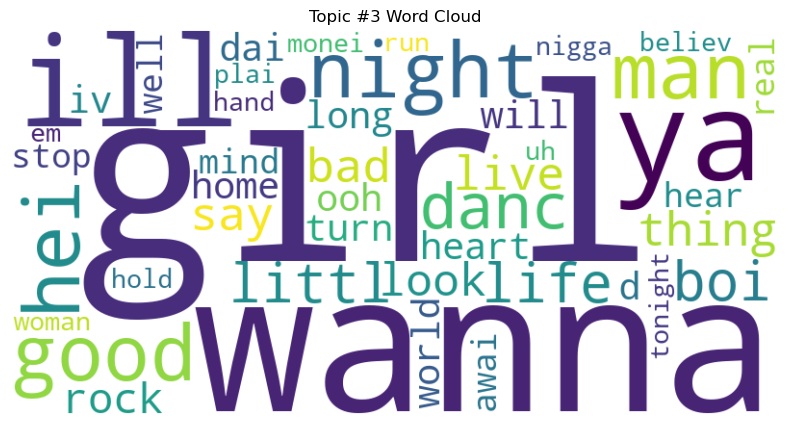

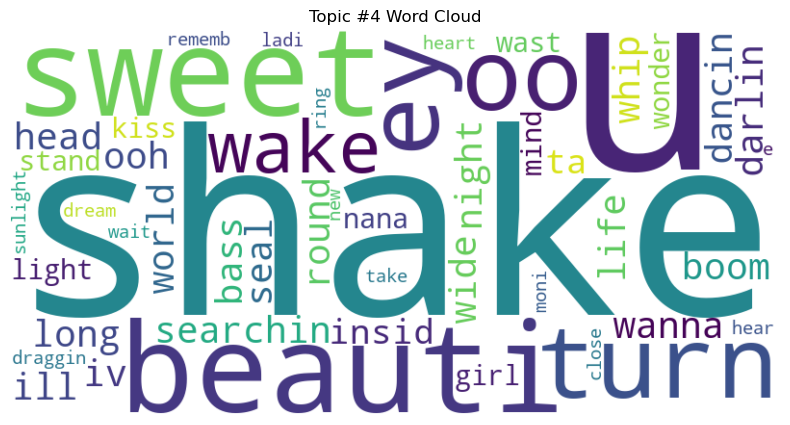

In [36]:
plot_word_clouds(lda_model, dictionary)

### Top2Vec

In [37]:
# texts = df['processed_lyrics'].apply(lambda x: ' '.join(x)).tolist()
texts = df['lyrics'].tolist()

# Top2Vec training
model = Top2Vec(documents=texts,
                min_count=10,  # words have to occur at least 10 times to be regarded
                embedding_model = "doc2vec",  # embeddings are created with doc2vec
                umap_args={"random_state":17})

2023-05-26 17:16:06,016 - top2vec - INFO - Pre-processing documents for training
2023-05-26 17:16:09,623 - top2vec - INFO - Creating joint document/word embedding
2023-05-26 17:20:40,604 - top2vec - INFO - Creating lower dimension embedding of documents
2023-05-26 17:21:20,740 - top2vec - INFO - Finding dense areas of documents
2023-05-26 17:21:20,856 - top2vec - INFO - Finding topics


In [38]:
# get recommendation for number of topics
model.get_num_topics()

2

In [39]:
model.topic_words

array([['someone', 'fears', 'strong', 'movinkeep', 'to', 'never', 'else',
        'youd', 'gave', 'sense', 'myself', 'each', 'believe', 'pray',
        'meit', 'cara', 'could', 'shoop', 'alone', 'cry', 'youand',
        'earth', 'being', 'heaven', 'feeli', 'mistakes', 'same', 'lungs',
        'made', 'itd', 'stayi', 'theres', 'not', 'hope', 'duff', 'tried',
        'couldnt', 'pain', 'trying', 'things', 'sometimes', 'youbut',
        'but', 'or', 'faith', 'daythe', 'be', 'instead', 'reason',
        'would'],
       ['na', 'nana', 'jude', 'ipod', 'tool', 'replay', 'stepper', 'ey',
        'jiggy', 'murderer', 'shelter', 'nanana', 'ina', 'melody',
        'symphony', 'gangster', 'goodbye', 'lyrical', 'singin',
        'tonightyou', 'link', 'impress', 'ex', 'eh', 'approach', 'erase',
        'gown', 'werent', 'mansion', 'uhh', 'moves', 'rush', 'funk',
        'foreplay', 'riches', 'oohooh', 'test', 'nanananana', 'yah',
        'consider', 'everyday', 'coz', 'movement', 'whips', 'gentlema

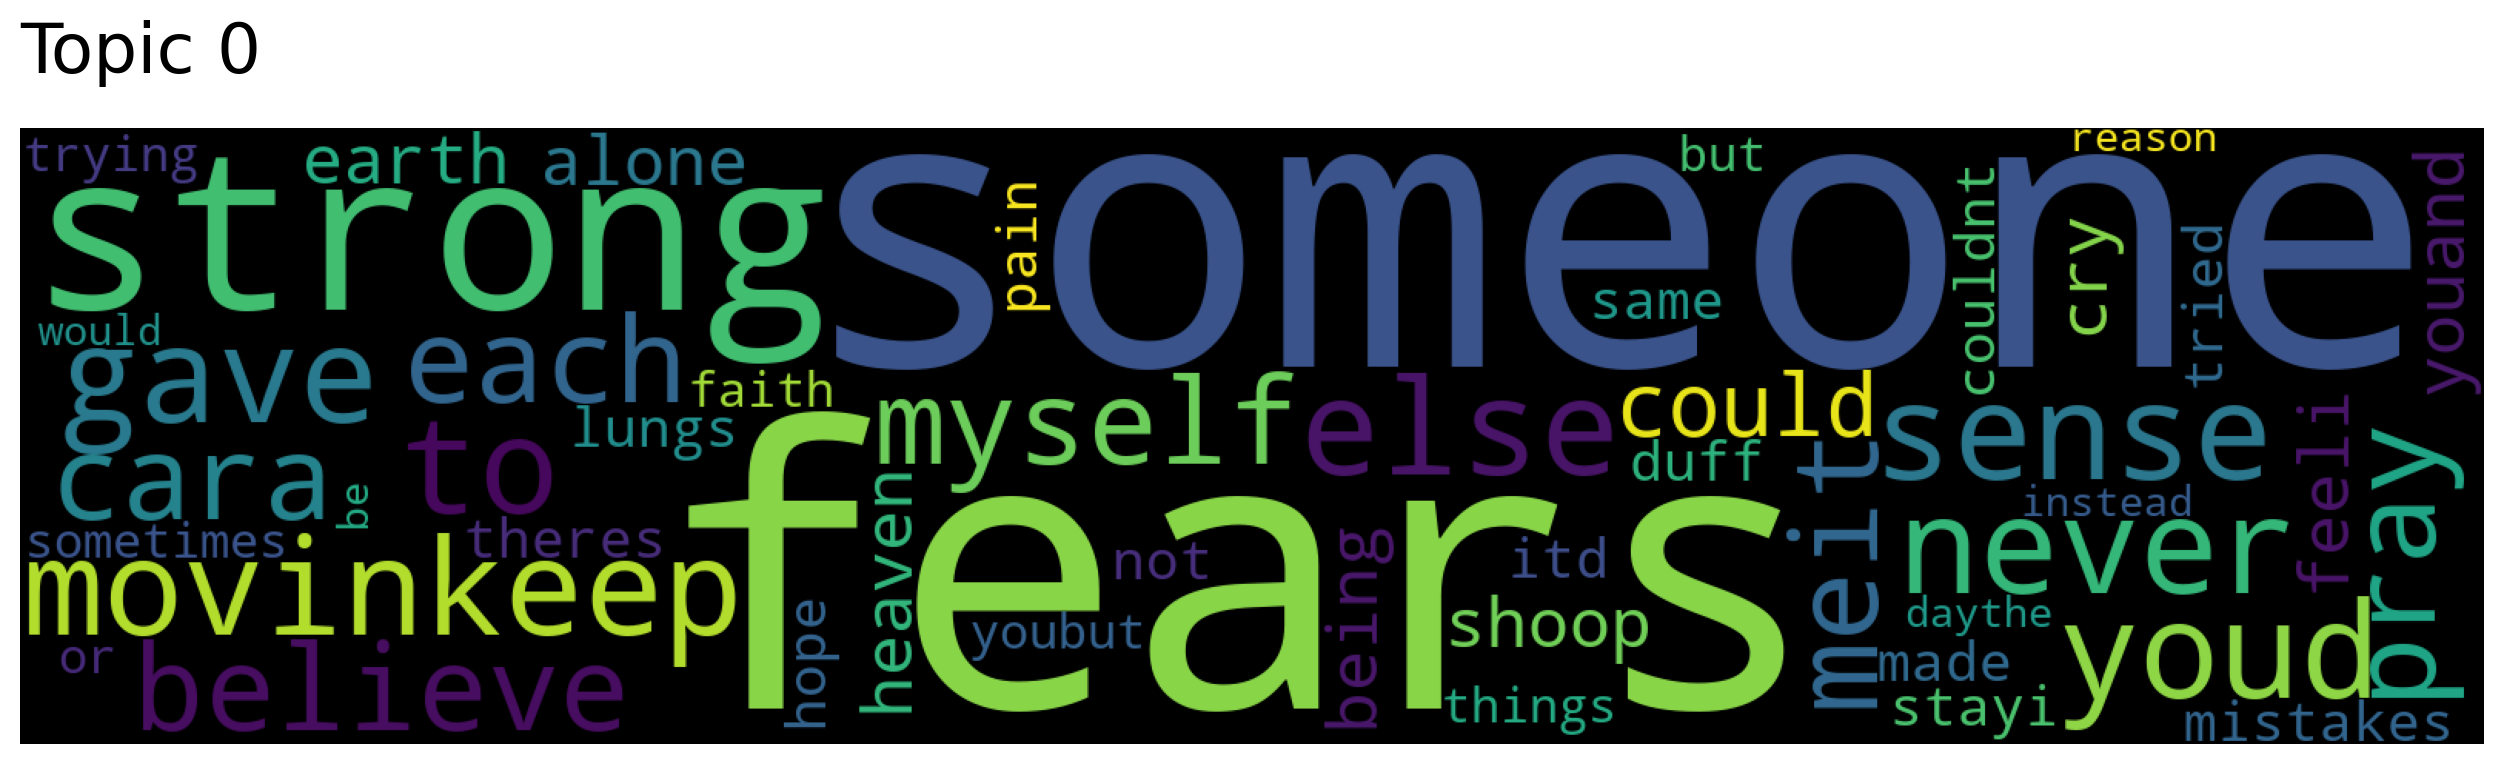

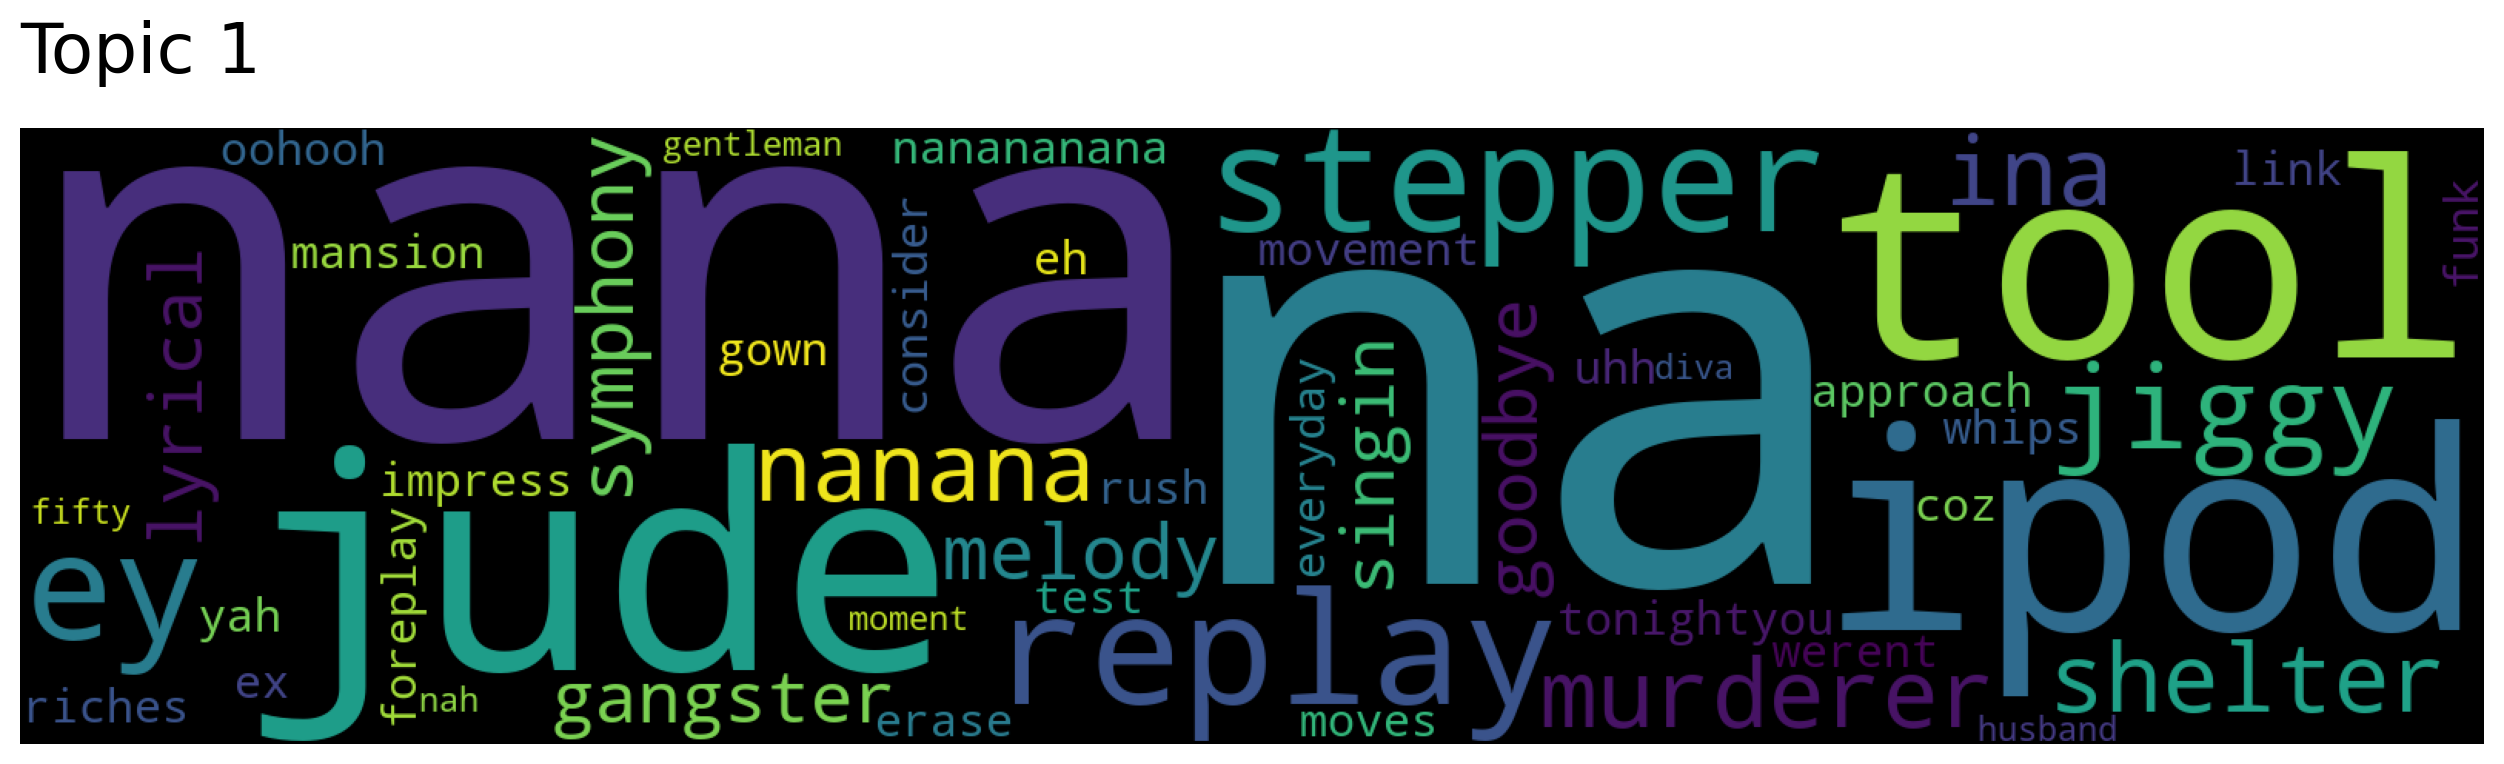

In [40]:
for n in list(range(0,len(model.topic_words))):
  model.generate_topic_wordcloud(n)